In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import os

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset Paths
dataset_path = "/content/drive/MyDrive/kidney_cancer_dataset"
train_path = os.path.join(dataset_path, "DATASET/train")
val_path = os.path.join(dataset_path, "DATASET/val")

In [ ]:
# Image size & batch size
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
# Augmentation & Normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5897 images belonging to 2 classes.
Found 1473 images belonging to 2 classes.


In [ ]:
# Compute Class Weights , balancing the dataset
y_train = train_data.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.7242692213215426), 1: np.float64(1.6147316538882803)}


In [ ]:
# Load Pretrained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:15]:  # Unfreeze last few layers for fine-tuning
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train Model
history = model.fit(train_data, validation_data=val_data,
                    epochs=15, class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 1664s 9s/step - accuracy: 0.6990 - loss: 0.5728 - val_accuracy: 0.9606 - val_loss: 0.0966
Epoch 2/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 146s 789ms/step - accuracy: 0.9625 - loss: 0.1156 - val_accuracy: 0.9457 - val_loss: 0.1446
Epoch 3/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 147s 796ms/step - accuracy: 0.9825 - loss: 0.0528 - val_accuracy: 0.9925 - val_loss: 0.0198
Epoch 4/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 146s 790ms/step - accuracy: 0.9909 - loss: 0.0253 - val_accuracy: 0.9980 - val_loss: 0.0089
Epoch 5/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 147s 793ms/step - accuracy: 0.9849 - loss: 0.0498 - val_accuracy: 0.9925 - val_loss: 0.0217
Epoch 6/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 157s 851ms/step - accuracy: 0.9944 - loss: 0.0185 - val_accuracy: 0.9484 - val_loss: 0.1379
Epoch 7/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 156s 845ms/step - accuracy: 0.9958 - loss: 0.0123 - val_accuracy: 0.9959 - val_loss: 0.0118
Epoch 8/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 141s 765ms/step - accuracy: 0.9939 - l

In [ ]:
# Evaluate Model
loss, acc = model.evaluate(val_data)
print(f"Validation Accuracy: {acc:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 600ms/step - accuracy: 0.9968 - loss: 0.0093
Validation Accuracy: 1.00


In [ ]:
# Predictions & Classification Report
y_true = val_data.classes
y_pred_probs = model.predict(val_data)
y_pred = (y_pred_probs > 0.6).astype(int)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Tumor']))

47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 592ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.69      0.69      0.69      1016
       Tumor       0.32      0.33      0.32       457

    accuracy                           0.57      1473
   macro avg       0.51      0.51      0.51      1473
weighted avg       0.58      0.57      0.58      1473



In [ ]:
# Save Model
model.save("/content/drive/MyDrive/kidney_cancer_vgg16_balanced.h5")

KeyboardInterrupt: 

In [ ]:
# Load Model for Testing
model = tf.keras.models.load_model("/content/drive/MyDrive/kidney_cancer_vgg16_balanced.h5")

ValueError: No model config found in the file at /content/drive/MyDrive/kidney_cancer_vgg16_balanced.h5.

Saving Tumor- (1053).jpg to Tumor- (1053).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


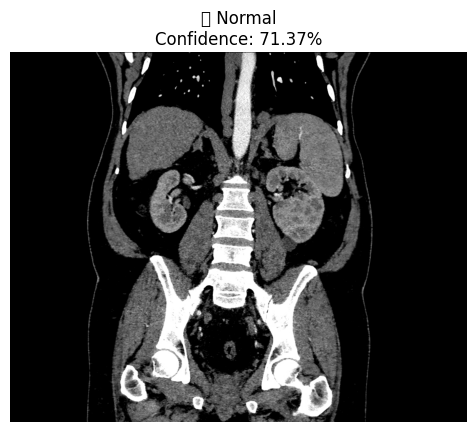

🔍 Prediction: 🟢 Normal (Confidence: 71.37%)


In [ ]:
# Upload & Predict Image
def predict_image():
    from google.colab import files
    import cv2
    uploaded = files.upload()

    for filename in uploaded.keys():
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.expand_dims(img, axis=0) / 255.0  # Normalize

        pred_prob = model.predict(img)[0][0]
        confidence = pred_prob if pred_prob > 0.5 else (1 - pred_prob)
        prediction = "🔴 Tumor" if pred_prob > 0.6 else "🟢 Normal"

        # Show Image
        plt.imshow(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"{prediction}\nConfidence: {confidence:.2%}")
        plt.show()

        print(f"🔍 Prediction: {prediction} (Confidence: {confidence:.2%})")

# Run Prediction
predict_image()